# Стратегия взаимодействия с пользователями 

## Цель:

Провести анализ и подготовить план действий по удержанию клиентов

## Задачи:

1. спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. составить портрет клиента;
3. вывить признаки, влияющие на отток.

## Описание данных

- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга»
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
- 'Churn' — факт оттока в текущем месяце

## Содержание

[1. Предобработка данных](#step1)  
[2. Модель прогнозирования](#step2)  
[3. Кластеризация пользователей](#step3)  
[4. Выводы и рекомендации](#step4)

## <a id='step1'> 1. Предобработка данных </a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('gym_churn.csv')
df.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1280,1,1,0,0,1,1,0,30,251.718580,1.0,7,3.235067,3.336254,0
876,0,1,1,1,1,6,0,31,248.356955,6.0,1,2.125058,2.051480,1
1908,0,1,0,0,1,6,1,24,173.227360,6.0,2,4.588925,4.586913,0
2887,0,1,1,0,1,1,0,31,162.128853,1.0,7,4.497186,4.504537,0
2152,1,1,1,1,1,12,0,32,242.040987,11.0,0,3.142519,3.057465,0


Для удобство работы заменим заглавные буквы в шапке таблицы на строчные

In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Пропусков нет

In [5]:
df.month_to_end_contract.value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

Изменим тип столбца `month_to_end_contract` на int

In [6]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

In [7]:
df.month_to_end_contract.value_counts()

1     2207
6      645
12     524
11     181
5      130
10      82
9       73
4       58
8       38
7       25
3       23
2       14
Name: month_to_end_contract, dtype: int64

<span style="color:blue">Изучим средние значения и стандартные отклонения</span>

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


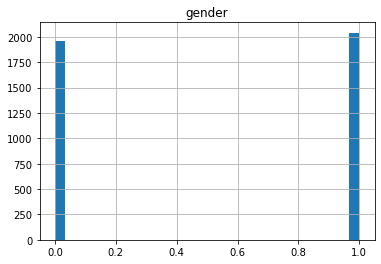

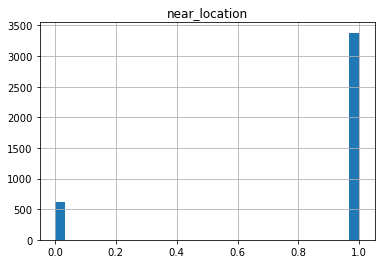

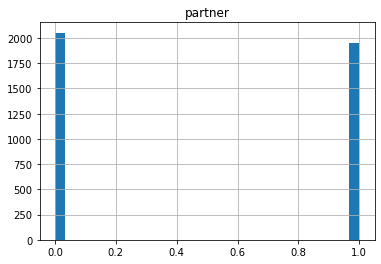

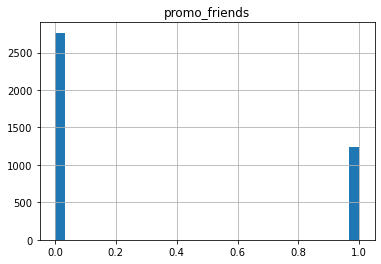

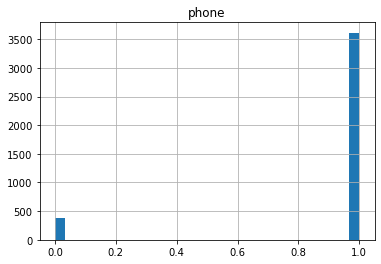

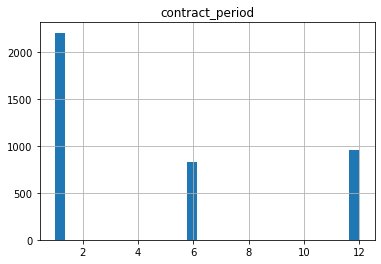

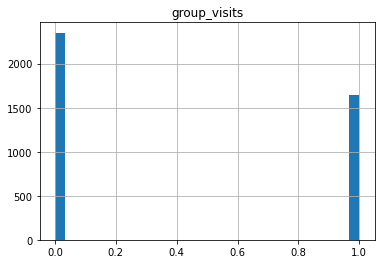

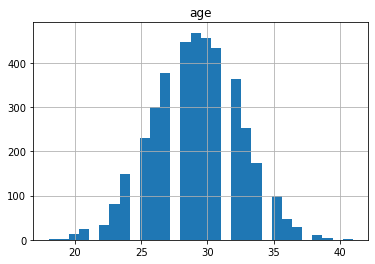

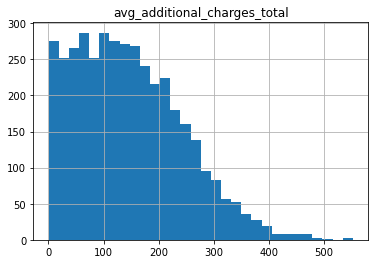

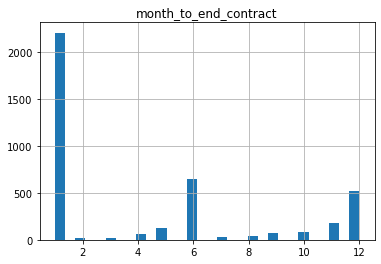

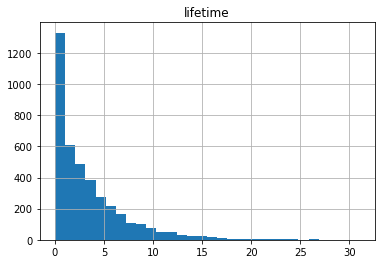

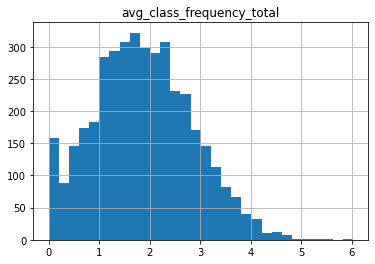

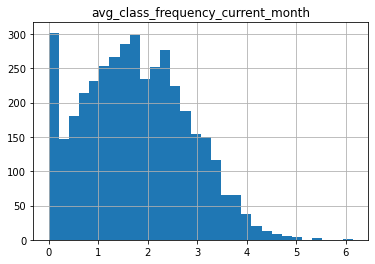

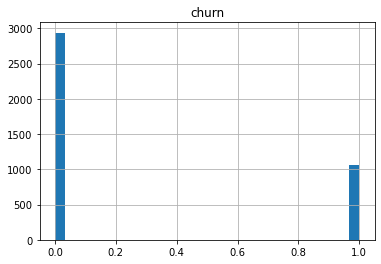

In [9]:
for features in df.describe().columns:
    df.hist(column=features, bins=30)

Выводы по признакам: 
- распределение по полу примерно одинаковое;
- большая часть клиентов работает или живет рядом;
- распределение клиентов с/без партнеоской программой примерно одинаковое;
- трель клиентов приходит от друзей;
- большая часть клиентов оставляет моб телефоны;
- клиенты заинтересованы в месячных абонементах;
- соотношение негрупповых к групповым тренировкам ~ 5:3;
- возрастная группа 25-35 лет;
- на доп покупки приходятся около 200 у.е.;
- у большинства клиентов до конца абонемента остался 1 месяц;
- большая текучка клиентов;
- ср частота посещений ~2 раза в неделю;
- ср частота посещений в этом месяце ~1,5 раза в неделю;
- ~25% составляет отток.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int32  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

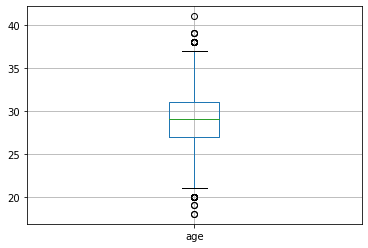

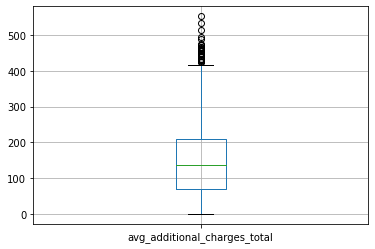

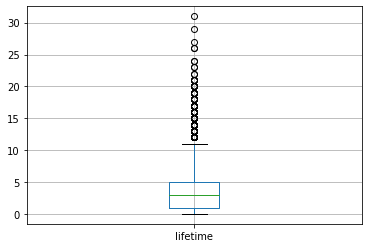

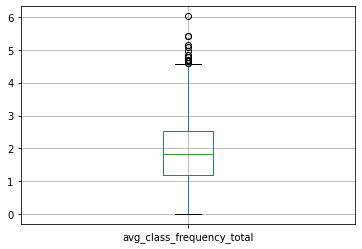

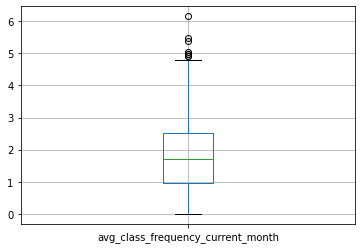

In [11]:
list_cont_value = ['age', 'avg_additional_charges_total', 'lifetime','avg_class_frequency_total','avg_class_frequency_current_month']
for features in list_cont_value:
    df.boxplot(features)
    plt.show()

Вывод по выбросам:
1. cтандартное отклонение у большинства признаков не больше ср значения;  
2. незначительные выбросы по возрасту и частоте посещений;  
3. выбросы по lifetime (имеет незначительное число стареньких клиентов) и по доп тратам (незначительная часть клиентов траят более 400 у.е.)

Ярко-выраженный аномалий нет, данные резать не будем.

<span style="color:blue">Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался </span>

In [12]:
df.groupby('churn').mean().style.format('{:.1f}')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.5,0.9,0.5,0.4,0.9,5.7,0.5,30.0,158.4,5.3,4.7,2.0,2.0
1,0.5,0.8,0.4,0.2,0.9,1.7,0.3,27.0,115.1,1.7,1.0,1.5,1.0


Особенности людей, уходящих в отток:
1. берут абонемент на маленький срок ~1-2 месяца;
2. меньшее кол-во клиентов по партнерской программе;
2. меньше посещают групповые занятия;
3. уходят после 1 месяца;
4. меньше частота посящений в неделю ~1-1,5 раза;

<span style="color:blue">Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался</span>

In [13]:
#разделим признаки на бинарные и непрерывные:
binar = ['contract_period','gender','near_location','partner','promo_friends','phone','group_visits','month_to_end_contract']
cont = ['age','avg_additional_charges_total','lifetime','avg_class_frequency_total','avg_class_frequency_current_month']

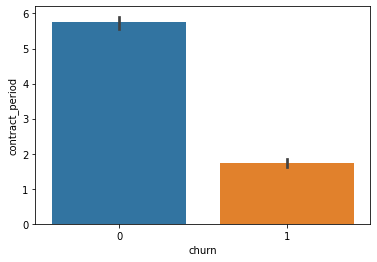

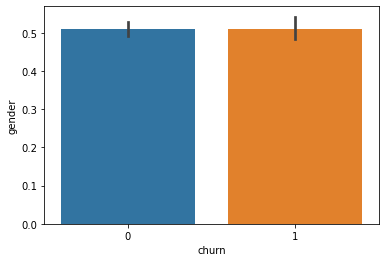

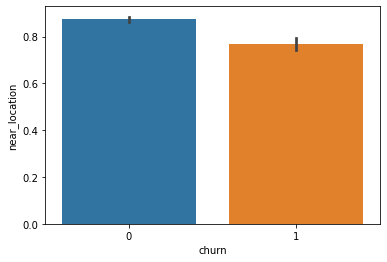

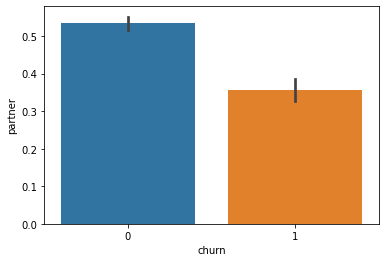

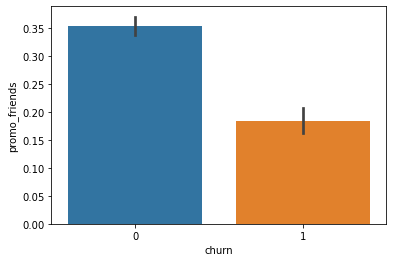

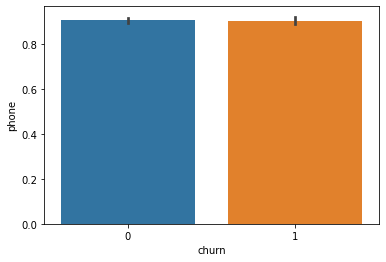

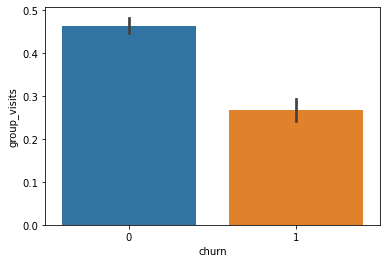

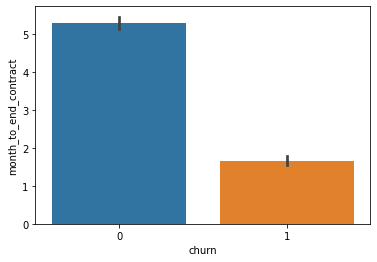

In [14]:
for element in binar:
    sns.barplot(data=df, x='churn', y=element)
    plt.show();

age


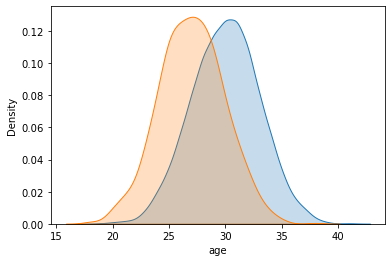

avg_additional_charges_total


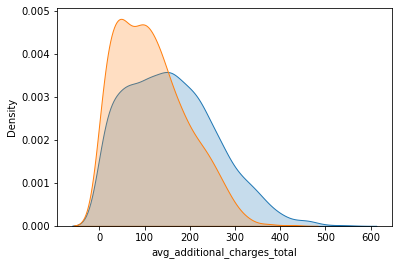

lifetime


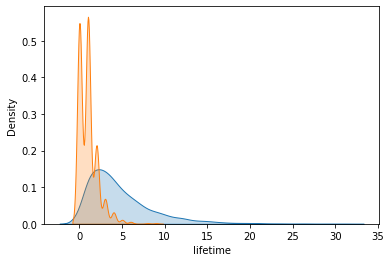

avg_class_frequency_total


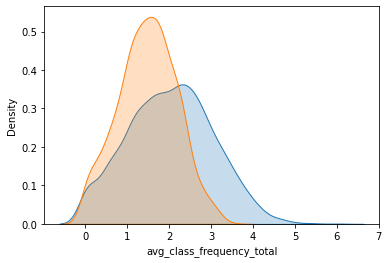

avg_class_frequency_current_month


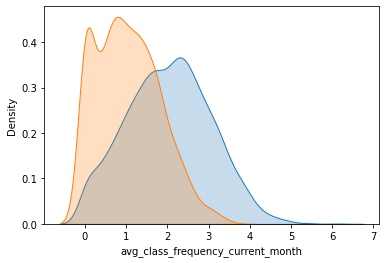

In [15]:
for element in cont:
    print(element)
    sns.kdeplot(df.query('churn == 0')[element], shade=True, label='Не отток')
    sns.kdeplot(df.query('churn == 1')[element], shade=True, label='Отток')
    plt.show()

Построим матрицу корреляции

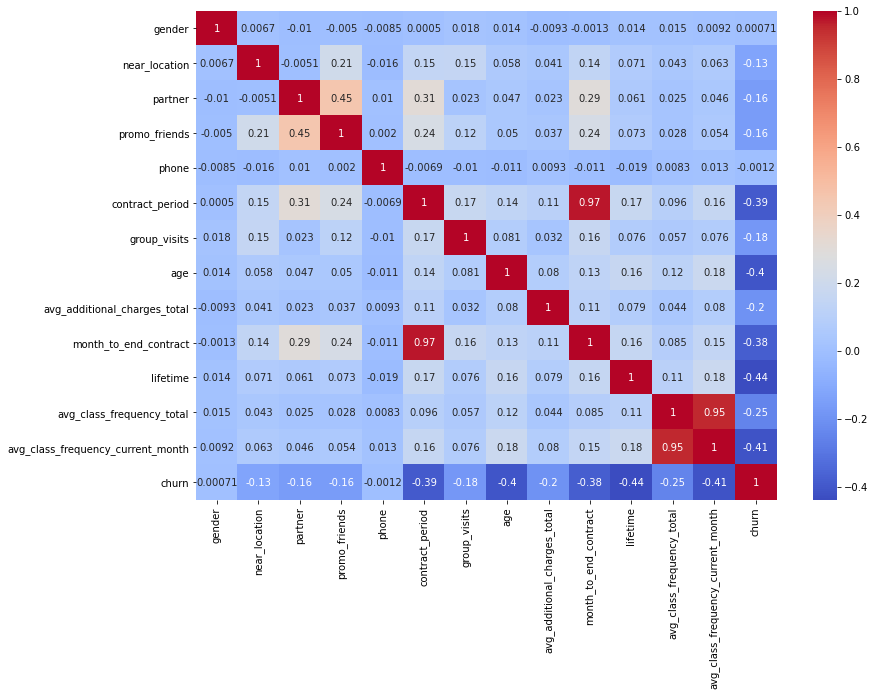

In [16]:
cm = df.corr()

plt.figure(figsize=(13, 9))
sns.heatmap(cm, annot=True, cmap="coolwarm")
plt.show()

Сильно коррелируют признаки:
- `Month_to_end_contract` и `Contract_period`;
- `Avg_class_frequency_current_month` и `Avg_class_frequency_total` 

<span style="color:blue"> Выводы </span>

1. Пропусков нет;  
2. Выбросы:  
2.1. cтандартное отклонение у большинства признаков не больше ср значения;  
2.2. незначительные выбросы по возрасту и частоте посещений;  
2.3. есть выбросы по lifetime (имеет незначительное число стареньких клиентов) и по доп тратам (незначительная часть клиентов траят более 400 у.е.)
3. Особенности людей, уходящих в отток:  
3.1. берут абонемент на маленький срок ~1-2 месяца;  
3.2. меньшее кол-во клиентов по партнерской программе;  
3.2. меньше посещают групповые занятия;  
3.3. уходят после 1 месяца;  
3.4. меньше частота посящений в неделю ~1-1,5 раза;  
4. Корреляция признаков:  
4.1. `Month_to_end_contract` и `Contract_period`;  
4.2. `Avg_class_frequency_current_month` и `Avg_class_frequency_total`   

## <a id='step2'>2. Модель прогнозирования</a>

Выделим целевую переменную и признаки

Создадим функцию, которая выводит метрики

In [17]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    
    """ 
    Функция выводит метрики для сравнения моделей прогнозирования
    
    Args:
        y_true: факт
        y_pred: прогноз
        y_proba: вероятность
        title: название модели

    Returns:
        вывод метрик accuracy_score, precision_score, recall_score
    """
   
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

Для анализа уберем коррелирующие признаки, а именно:`Month_to_end_contract` и `Avg_class_frequency_current_month`

In [18]:
X = df.drop(['churn','month_to_end_contract','avg_class_frequency_current_month'], axis=1)
y = df.churn

Разделим на обучающую и валидационную выборки

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные

In [20]:
scaler = StandardScaler()
scaler.fit(X_train) #обучение
X_train_st = scaler.transform(X_train) #стандартизация
X_test_st = scaler.transform(X_test) #стандартизация

Зададим алгоритм для модели логистической регрессии

In [21]:
lg_model = LogisticRegression(random_state=0)
lg_model.fit(X_train_st,y_train) #обучение

lg_prediction = lg_model.predict(X_test_st) #прогноз
lg_probabilities = lg_model.predict_proba(X_test_st)[:,1] #вероятность
print_all_metrics(y_test, lg_prediction, lg_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81


Зададим алгоритм для модели случайный лес

In [22]:
rf_model = RandomForestClassifier(n_estimators =100, random_state=0)
rf_model.fit(X_train_st,y_train)

rf_prediction = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test,rf_prediction,rf_probabilities,title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.76


Выведем влияние признаков:

In [23]:
lg_model.coef_

array([[ 0.04945669, -0.08812035, -0.05305468, -0.21795267, -0.12000079,
        -1.31655178, -0.35976961, -1.09321818, -0.56707174, -3.87968776,
        -0.73046927]])

In [24]:
rf_model.feature_importances_

array([0.01735259, 0.01348935, 0.01739539, 0.01757201, 0.00995539,
       0.11352804, 0.0229181 , 0.14587204, 0.13760716, 0.33662746,
       0.16768247])

Вывод

Логистическа регрессия показывает лучшие результаты по Precision и recall.  
Стоит отметить, что в нашем случае показатель precision имеет большую значимость, чем recall,   
т.к. мы можем потратить лишние деньги для клиента, который уйдет.

## <a id='step3'>3. Кластеризация пользователей </a>

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

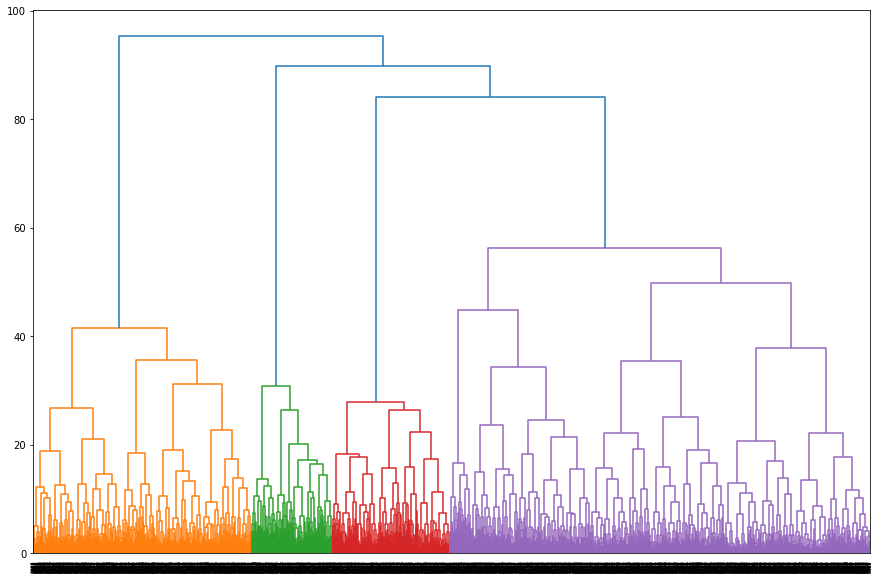

In [25]:
sc = StandardScaler() #стандартизация данных перед работой с алгоритмами
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Агломеративная кластеризация предложила 4 группы.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [26]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters=5)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

In [27]:
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels
# выводим статистику по средним значениям наших признаков по кластеру
clusters_features_mean = df.groupby(['cluster_km']).mean().reset_index()
clusters_features_mean.style.format('{:.1f}')

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0.0,0.5,1.0,0.9,1.0,1.0,6.9,0.5,29.5,152.5,6.3,4.2,2.0,1.9,0.1
1,1.0,0.5,1.0,0.2,0.1,1.0,2.0,0.3,27.9,121.6,1.9,2.0,1.5,1.3,0.5
2,2.0,0.5,0.9,0.5,0.3,0.0,4.8,0.4,29.3,144.2,4.5,3.9,1.9,1.7,0.3
3,3.0,0.5,1.0,0.4,0.0,1.0,6.8,0.5,30.8,181.9,6.2,5.8,2.3,2.3,0.0
4,4.0,0.5,0.0,0.5,0.1,1.0,3.0,0.2,28.7,137.3,2.8,3.0,1.8,1.6,0.4


Кластеры 1 и 3 наиболее подвержены оттоку, доля оттока 40% и 50%, обладают след характеристиками:
- берут абонемент на короткий срок;
- мало посещают групповые занятия;
- меньше тратят денег на доп продукты/услуги фитнеса;
- новые клиенты;
- низкая частота посещения (1р в неделю).

Построим распределения признаков для кластеров

In [28]:
#разделим признаки на бинарные и непрерывные:
binar = ['gender','near_location','partner','promo_friends','phone','group_visits','churn']
cont = ['contract_period','age','avg_additional_charges_total','month_to_end_contract','lifetime','avg_class_frequency_total','avg_class_frequency_current_month']

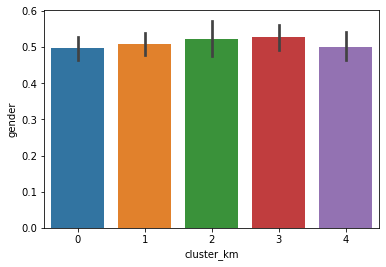

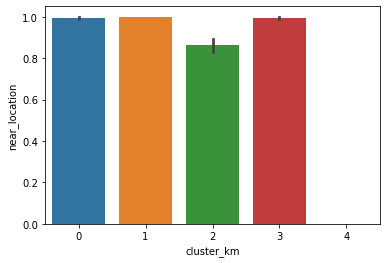

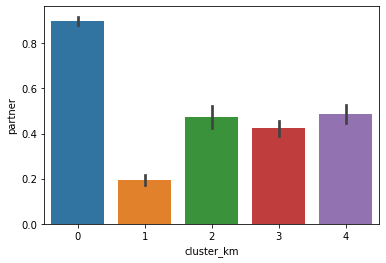

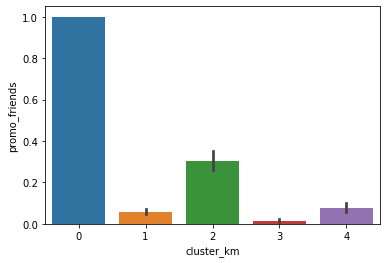

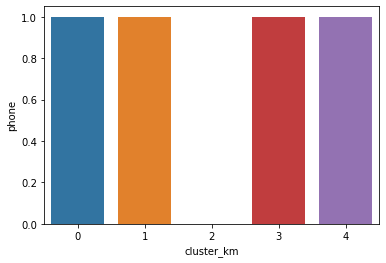

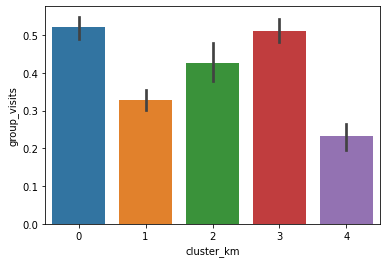

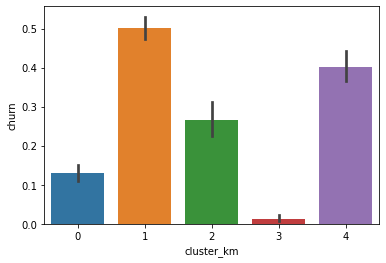

In [29]:
for element in binar:
    sns.barplot(data=df, x='cluster_km', y=element)
    plt.show();

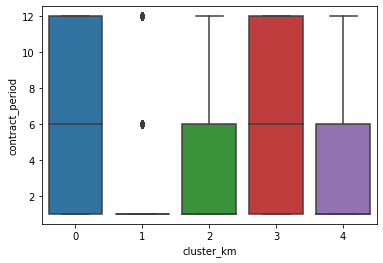

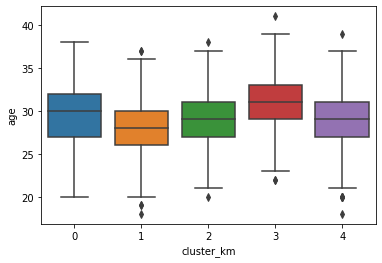

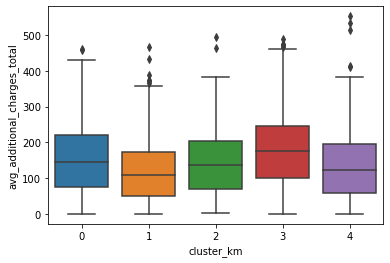

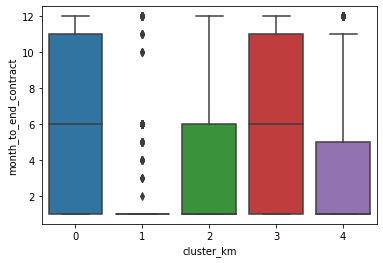

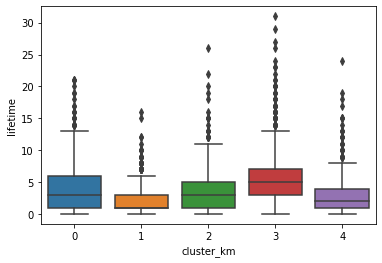

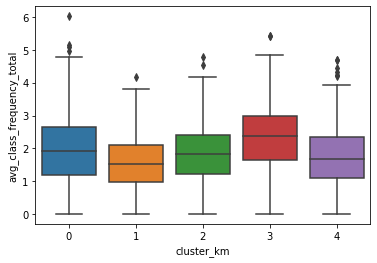

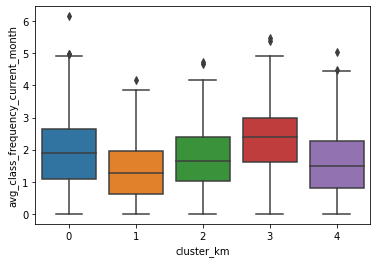

In [30]:
for element in cont:
    sns.boxplot(data=df, x='cluster_km', y=element)
    plt.show();

## <a id='step4'>4. Выводы и рекомендации </a>

<span style="color:blue"> Выводы </span>

Портрет клиента:
- женщины и мужчины примерно в равных пропорциях;
- ср возраст 30 лет;
- живут или работают рядом с фитнес-центром;
- посещают занятия 2 раза в неделю;
- любят групповые тренировки.

На отток клиентов влияет:
- частота посещений занятий;
- посещаемость групповых тренировок;
- длительность абонемента.

Логистическая регрессия показала результаты лучше, чем случайный лес по показатедю recall и precision.

<span style="color:blue"> Рекомендации </span>

1. Новым клиентам давать скидку на первый абонемент с большой длительностью.

2. Сделать упор на групповые занятия:
    - рассказывать клиентам про групповые занятия; 
    - увеличить разнообразие групповых занятий;
    - ввести соревновательный характер на групповых занятиях.  

3. Повысить частоту занятий:
    - Пиарить важность регулярности и определенной частоты занятий для достижений результатов;
    - ввести соревновательный момент - для новых клиентов с регулярным посещением подарить бонус.